<a href="https://colab.research.google.com/github/IP-Capston-Mosaic/IP-Capston-Mosaic/blob/jeongseock/OCR_Enhance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install easyocr
!pip install opencv-python-headless==4.1.2.30

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement opencv-python-headless==4.1.2.30 (from versions: 3.4.10.37, 3.4.11.39, 3.4.11.41, 3.4.11.43, 3.4.11.45, 3.4.13.47, 3.4.14.51, 3.4.14.53, 3.4.15.55, 3.4.16.59, 3.4.17.61, 3.4.17.63, 3.4.18.65, 4.3.0.38, 4.4.0.40, 4.4.0.42, 4.4.0.44, 4.4.0.46, 4.5.1.48, 4.5.2.52, 4.5.2.54, 4.5.3.56, 4.5.4.58, 4.5.4.60, 4.5.5.62, 4.5.5.64, 4.6.0.66, 4.7.0.68, 4.7.0.72)
ERROR: No matching distribution found for opencv-python-headless==4.1.2.30


In [ ]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

In [ ]:
import matplotlib.font_manager as fm

sys_font=fm.findSystemFonts()

nanum_font = [f for f in sys_font if 'Nanum' in f]
nanum_font

['/usr/share/fonts/truetype/nanum/NanumBrush.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoEco.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoExtraBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoEcoBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumPen.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothicUltraLight.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareL.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunpenB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareEB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothicLight.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf',
 '/usr/share/fonts/truetype/nanum

In [ ]:
from matplotlib import pyplot as plt
from imutils.perspective import four_point_transform
from imutils.contours import sort_contours
import imutils
from easyocr import Reader
import cv2
import requests
import numpy as np
from PIL import ImageFont, ImageDraw, Image, ImageEnhance


In [ ]:
def plt_imshow(title='image', img=None, figsize=(8 ,5)):
    plt.figure(figsize=figsize)

    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []

            for i in range(len(img)):
                titles.append(title)

        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)

            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])

        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()


def make_scan_image(image, width, ksize=(5,5), min_threshold=75, max_threshold=200):
  image_list_title = []
  image_list = []

  image = imutils.resize(image, width=width)
  ratio = org_image.shape[1] / float(image.shape[1])

  # 이미지를 grayscale로 변환하고 blur를 적용
  # 모서리를 찾기위한 이미지 연산
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, ksize, 0)
  edged = cv2.Canny(blurred, min_threshold, max_threshold)

  image_list_title = ['gray', 'blurred', 'edged']
  image_list = [gray, blurred, edged]

  # contours를 찾아 크기순으로 정렬
  cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

  findCnt = None

  # 정렬된 contours를 반복문으로 수행하며 4개의 꼭지점을 갖는 도형을 검출
  for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)

    # contours가 크기순으로 정렬되어 있기때문에 제일 첫번째 사각형을 영역으로 판단하고 break
    if len(approx) == 4:
      findCnt = approx
      break


  # 만약 추출한 윤곽이 없을 경우 오류
  if findCnt is None:
    raise Exception(("Could not find outline."))


  output = image.copy()
  cv2.drawContours(output, [findCnt], -1, (0, 255, 0), 2)
  
  image_list_title.append("Outline")
  image_list.append(output)

  # 원본 이미지에 찾은 윤곽을 기준으로 이미지를 보정
  transform_image = four_point_transform(org_image, findCnt.reshape(4, 2) * ratio)

  plt_imshow(image_list_title, image_list)
  plt_imshow("Transform", transform_image)

  return transform_image


def putText(cv_img, text, x, y, color=(0, 0, 0), font_size=22):
  # Colab이 아닌 Local에서 수행 시에는 gulim.ttc 를 사용하면 됩니다.
  # font = ImageFont.truetype("fonts/gulim.ttc", font_size)
  font = ImageFont.truetype('/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf', font_size)
  img = Image.fromarray(cv_img)
   
  draw = ImageDraw.Draw(img)
  draw.text((x, y), text, font=font, fill=color)

  cv_img = np.array(img)
  
  return cv_img

대비값 조정 -> 오히려 글씨 뭉게지는 효과

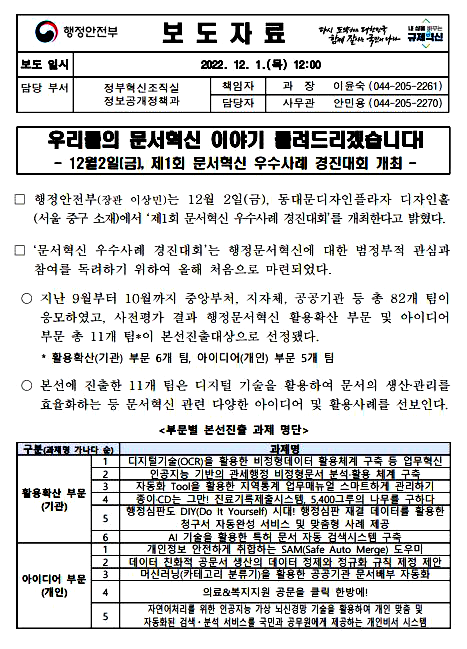

In [ ]:
img = Image.open("scantest.JPG")

org_image = ImageEnhance.Contrast(img).enhance(2)
org_image.show("orignal image2", org_image)